In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import sys
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/"
    
torch.cuda.empty_cache() 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())

11.7
GPU: True


# How to use
Most things are set up lready to work. You will need a pretrained autoencoder network. This will then download the same dataset and create a model that uses the pretrained encoder for a meaningful neural network. 

#### ToDo
Needs to finish modified encoder
Needs to edit and test training loop
Need to test on untrained unseen data

## Setup

In [26]:
def sort_data(name,vibration=True,dir="all"):
    df = pd.read_csv(path+name)
    df=pd.DataFrame(df).fillna(0)
    if vibration:
        x=np.array([df['s1'],df['s2'],df['s3'],df['s4'],df['s5'],df['s6']])
    else:
        x=np.array([df['s1'],df['s2'],df['s5'],df['s6']])
    if dir=="left":
        x=np.array([df['s1'],df['s2'],df['s3']])
    elif dir=="right":
        x=np.array([df['s4'],df['s5'],df['s6']])
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    nan_indices = np.where(np.isnan(y))
    y[nan_indices]=0
    print("X data:",x.shape,"/ny data:",y.shape)
    return x,y


def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y


def augmented_pattern(x,y):
    isMod=False
    while not isMod:
        chunk_size=np.random.randint(5,100)
        if len(x[0])%chunk_size==0:
            isMod=True
    repetitions=np.random.randint(3,5)
    print(chunk_size)
    randomized_x = []
    randomized_y = []
    
    for idx, pattern in enumerate(x):
        pattern_length = len(pattern)
        num_chunks = pattern_length // chunk_size
        
        # Split pattern into chunks of size chunk_size
        chunks = [pattern[i * chunk_size: (i + 1) * chunk_size] for i in range(num_chunks)]
        
        for _ in range(repetitions):
            # Shuffle the chunks randomly
            np.random.shuffle(chunks)
            # Concatenate the shuffled chunks to create a new pattern
            randomized_pattern = np.concatenate(chunks)
            
            # Store the randomized pattern and corresponding label
            randomized_x.append(randomized_pattern)
            randomized_y.append(y[idx])
    
    return np.array(randomized_x), np.array(randomized_y)
def augmented_noise(X_):
    X=X_.copy()
    return X+np.random.normal(np.average(X),np.std(X)+1,X.shape)

def getAugmentedData(X,y,T):
    x,y=gen_temporal_data_2(X,y,T)
    x1=augmented_noise(x)
    x2,y1=augmented_pattern(x,y)
    x=np.concatenate([x,x1,x2])
    y=np.concatenate([y,y,y1])
    #reduction
    X_=(x-np.average(x))/np.std(x)
    y_=(y-np.average(y))/np.std(y)
    #split
    X_train, X_test, Y_train, Y_test = train_test_split(X_.astype(np.float32), y_.astype(np.float32), test_size=0.2, random_state=42)
    X_train=torch.tensor(X_train).to(device)
    X_test=torch.tensor(X_test).to(device)
    Y_train=torch.tensor(Y_train).to(device)
    Y_test=torch.tensor(Y_test).to(device)
    return X_train, X_test, Y_train, Y_test

def getData(X,y,T):
    X_,y_=gen_temporal_data_2(X,y,T)
    #reduction
    X_=(X_-np.average(X_))/np.std(X_)
    y=(y-np.average(y))/np.std(y)
    #split
    X_train, X_test, Y_train, Y_test = train_test_split(X_.astype(np.float32), y_.astype(np.float32), test_size=0.2, random_state=42)
    X_train=torch.tensor(X_train)
    X_test=torch.tensor(X_test)
    Y_train=torch.tensor(Y_train)
    Y_test=torch.tensor(Y_test)
    return X_train, X_test, Y_train, Y_test
# Define your Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, input_size),
            nn.ReLU(),
            nn.Linear(input_size, input_size)  # Output size is 3
        )
        #self.endlayer = nn.linear(input_size,output_size)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#setup new class 
class ModifiedEncoder(nn.Module):
    def __init__(self, base_encoder, encoding_dim, num_classes):
        super(ModifiedEncoder, self).__init__()
        self.base_encoder = base_encoder
        self.classification_layer = nn.Linear(encoding_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        encoded = self.base_encoder.encoder(x)
        classification_output = self.classification_layer(encoded)
        return classification_output
    
    

In [27]:

X,y=sort_data("accmovementLeftFoot.csv")
X1,y1=sort_data("accmovementRightFoot.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootCarpet.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootCarpet.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootConrete.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootConrete.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootOutdoor.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootOutdoor.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootCarpetDay2.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootCarpetDay2.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootCarpetDay3.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootCarpetDay3.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootDay4.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootDay4.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (3932, 6) /ny data: (3932, 3)
X data: (2214, 6) /ny data: (2214, 3)
X data: (2624, 6) /ny data: (2624, 3)
X data: (5560, 6) /ny data: (5560, 3)
X data: (8122, 6) /ny data: (8122, 3)
X data: (5187, 6) /ny data: (5187, 3)
X data: (9433, 6) /ny data: (9433, 3)
X data: (25122, 6) /ny data: (25122, 3)
X data: (10173, 6) /ny data: (10173, 3)
X data: (1976, 6) /ny data: (1976, 3)
X data: (2785, 6) /ny data: (2785, 3)


## Load data

In [28]:
input_size = 50 * 6
latent_size = 64  # Choose an appropriate size for the latent space
#load trained auto encoder
autoencoder = Autoencoder(input_size, latent_size).to(device)
autoencoder.load_state_dict(torch.load(path+"GPUCluster/data/"+"autoencoder_model.pth",map_location=torch.device('cpu')))
#create normal model
output=3
model=ModifiedEncoder(autoencoder,latent_size,output)
#model.base_encoder.load_state_dict(autoencoder.encoder.state_dict())
X_train, X_test, Y_train, Y_test=getAugmentedData(X,y,50)


25


In [29]:
x_train = X_train.view(-1, input_size)
x_test = X_test.view(-1, input_size)
print(x_train.shape,Y_train.shape)

torch.Size([501854, 300]) torch.Size([501854, 3])


## Train modified

In [32]:


# Define your optimizer and loss function
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

batch_size=64

# Training loop
num_epochs = 1000
history=[]
for epoch in range(num_epochs):
    # Forward pass
    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i + batch_size]
        targets = Y_train[i:i + batch_size]
        output = model(inputs)

        # Calculate the loss
        #loss_x = criterion(output, x)
        loss = criterion(output, targets)  # Use only the first 3 elements for Y
        #loss = loss_x + loss_y  # Combine both losses
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.append(loss.item())
        # Print progress
    if epoch%100==0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

torch.save(model.state_dict(), path+"GPUCluster/data/"+"autoencoder_mod_model.pth")

np.save(path+"GPUCluster/data/train_loss_new",np.array(history))

Epoch [1/1000], Loss: 0.0556
Epoch [101/1000], Loss: 0.0578
Epoch [201/1000], Loss: 0.0601
Epoch [301/1000], Loss: 0.0587
Epoch [401/1000], Loss: 0.0582
Epoch [501/1000], Loss: 0.0526
Epoch [601/1000], Loss: 0.0544
Epoch [701/1000], Loss: 0.0533
Epoch [801/1000], Loss: 0.0539
Epoch [901/1000], Loss: 0.0546


In [33]:
torch.save(model.state_dict(), path+"GPUCluster/data/"+"autoencoder_mod_model.pth")

np.save(path+"GPUCluster/data/train_loss_new",np.array(history))

## visualise

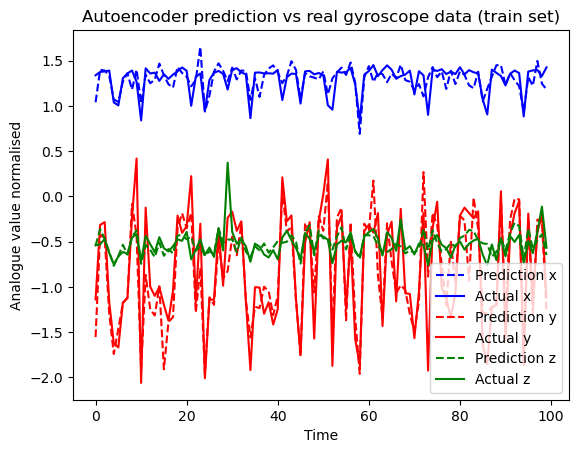

In [39]:
"""X_train, X_test, Y_train, Y_test=getAugmentedData(X,y,50)
x_train = X_train.view(-1, input_size)
x_test = X_test.view(-1, input_size)"""
outputs = model.forward(x_train)
start=0
end=100
plt.plot(outputs[start:end,0].cpu().detach().numpy(),"--",c="b",label="Prediction x")
plt.plot(Y_train[start:end,0].cpu().detach().numpy(),c="b",label="Actual x")

plt.plot(outputs[start:end,1].cpu().detach().numpy(),"--",c="r",label="Prediction y")
plt.plot(Y_train[start:end,1].cpu().detach().numpy(),c="r",label="Actual y")

plt.plot(outputs[start:end,2].cpu().detach().numpy(),"--",c="g",label="Prediction z")
plt.plot(Y_train[start:end,2].cpu().detach().numpy(),c="g",label="Actual z")
plt.xlabel("Time")
plt.ylabel("Analogue value normalised")
plt.title("Autoencoder prediction vs real gyroscope data (train set)")
plt.legend(loc="lower right")
plt.show()

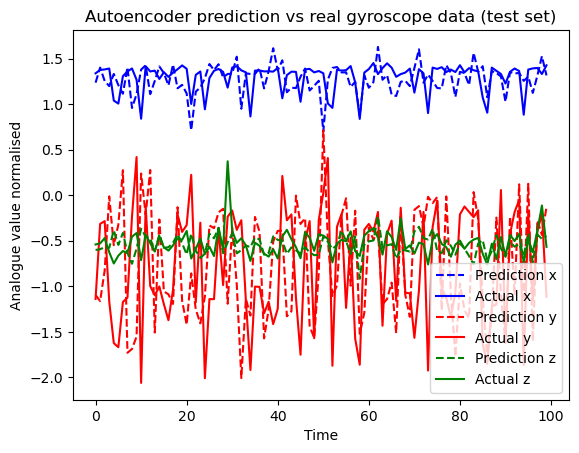

In [40]:
"""X_train, X_test, Y_train, Y_test=getAugmentedData(X,y,50)
x_train = X_train.view(-1, input_size)
x_test = X_test.view(-1, input_size)"""

#X_train, X_test, Y_train, Y_test=getData(X,y,50)

outputs = model.forward(x_test)
start=0
end=100
plt.plot(outputs[start:end,0].cpu().detach().numpy(),"--",c="b",label="Prediction x")
plt.plot(Y_train[start:end,0].cpu().detach().numpy(),c="b",label="Actual x")

plt.plot(outputs[start:end,1].cpu().detach().numpy(),"--",c="r",label="Prediction y")
plt.plot(Y_train[start:end,1].cpu().detach().numpy(),c="r",label="Actual y")

plt.plot(outputs[start:end,2].cpu().detach().numpy(),"--",c="g",label="Prediction z")
plt.plot(Y_train[start:end,2].cpu().detach().numpy(),c="g",label="Actual z")
plt.xlabel("Time")
plt.ylabel("Analogue value normalised")
plt.title("Autoencoder prediction vs real gyroscope data (test set)")
plt.legend(loc="lower right")
plt.show()

X data: (11000, 6) /ny data: (11000, 3)
X data: (8000, 6) /ny data: (8000, 3)


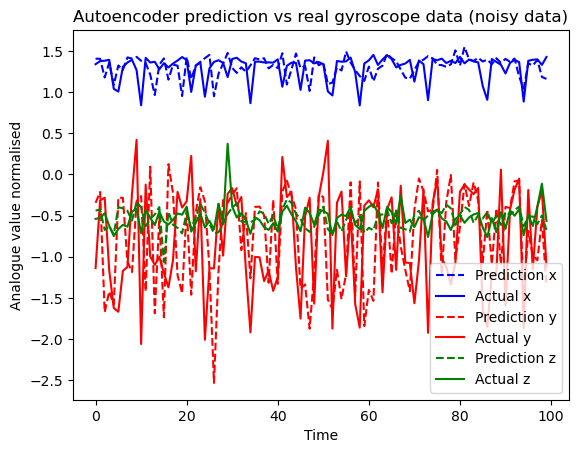

In [42]:
X1,y1=sort_data("accmovementLeftFootDay5.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootDay5.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)


X_train1, X_test1, Y_train1, Y_test1=getData(X,y,50)
x_train1 = X_train1.view(-1, input_size)
outputs = model.forward(x_train1)
start=0
end=100
plt.plot(outputs[start:end,0].cpu().detach().numpy(),"--",c="b",label="Prediction x")
plt.plot(Y_train[start:end,0].cpu().detach().numpy(),c="b",label="Actual x")

plt.plot(outputs[start:end,1].cpu().detach().numpy(),"--",c="r",label="Prediction y")
plt.plot(Y_train[start:end,1].cpu().detach().numpy(),c="r",label="Actual y")

plt.plot(outputs[start:end,2].cpu().detach().numpy(),"--",c="g",label="Prediction z")
plt.plot(Y_train[start:end,2].cpu().detach().numpy(),c="g",label="Actual z")
plt.xlabel("Time")
plt.ylabel("Analogue value normalised")
plt.title("Autoencoder prediction vs real gyroscope data (noisy data)")
plt.legend(loc="lower right")
plt.show()